<a href="https://colab.research.google.com/github/mountechsolutions/stock-price-forecasting/blob/master/Apple_Stock_Price_XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# Time series decomposition
!pip install stldecompose
from stldecompose import decompose

In [154]:
df = web.DataReader('CERN', data_source='yahoo', start='2000-01-01', end='2020-08-01')

In [155]:
df.to_csv('data.csv')

In [184]:
df = pd.read_csv('data.csv')

In [185]:
df.head()

Date      High       Low      Open     Close     Volume  Adj Close
0  2000-01-03  2.585938  2.460938  2.460938  2.554688   736800.0   2.521683
1  2000-01-04  2.554688  2.484375  2.531250  2.507812  1083200.0   2.475414
2  2000-01-05  2.515625  2.468750  2.515625  2.507812  1121600.0   2.475414
3  2000-01-06  2.507812  2.453125  2.492188  2.492188  1267200.0   2.459991
4  2000-01-07  2.546875  2.437500  2.472656  2.539062  1914400.0   2.506260

In [186]:
df['Date'] = pd.to_datetime(df['Date'])

In [187]:
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

In [188]:
fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=1, col=1)
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

# Decomposition

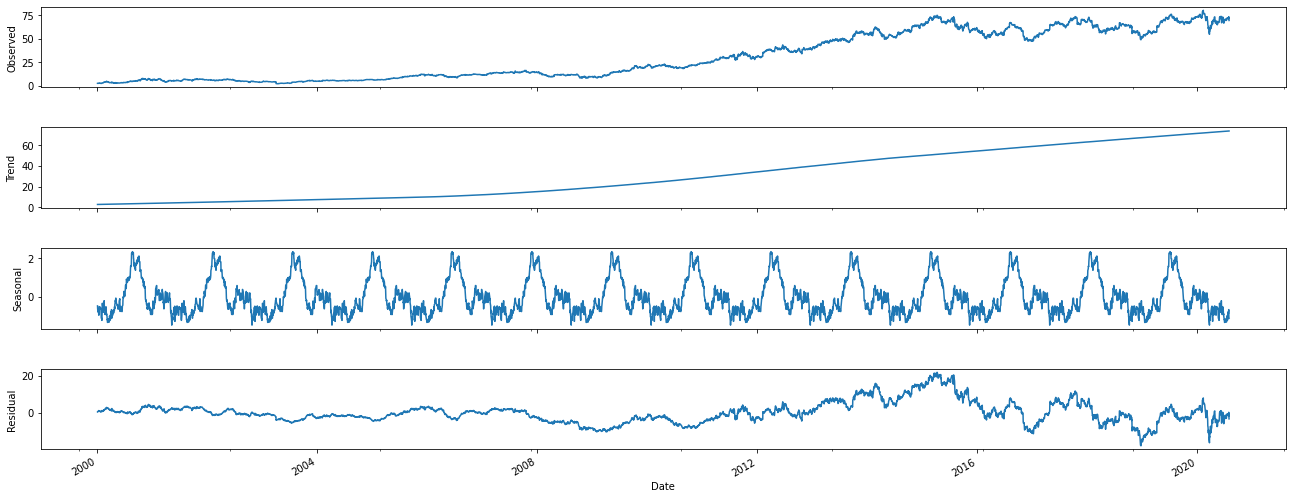

In [161]:
df_close = df[['Date', 'Close']].copy()
df_close = df_close.set_index('Date')
df_close.head()

decomp = decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)

# EMA => Exponential Moving Average
# SMA => Smooth Moving Average

#### SMA calculates the average of price data, while EMA gives more weight to current data. The newest price data will impact the moving average more, with older price data having a lesser impact.

In [189]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

# Relative Strength Index (RSI)
Relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset.

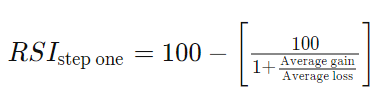

The average gain or loss used in the calculation is the average percentage gain or loss during a look-back period. The formula uses a positive value for the average loss. The standard is to use 14 periods to calculate the initial RSI value.

In [190]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

In [191]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [192]:
df = df[(df['Date'].dt.year >= 2012)].copy()

## Shift label column

## Drop invalid samples


In [193]:
df['Close'] = df['Close'].shift(-1)
# df = df.iloc[33:] # Because of moving averages
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

In [194]:
df.head()

Date       High        Low  ...        RSI      MACD  MACD_signal
0 2012-01-03  32.084999  31.174999  ...  63.540886  0.120292    -0.163133
1 2012-01-04  31.275000  30.815001  ...  65.760874  0.149901    -0.100526
2 2012-01-05  31.285000  30.655001  ...  72.741688  0.199711    -0.040479
3 2012-01-06  31.844999  31.235001  ...  80.345914  0.277941     0.023205
4 2012-01-09  32.064999  31.424999  ...  77.331197  0.323301     0.083224

[5 rows x 15 columns]

In [195]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))


In [196]:
train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

In [197]:
valid_df

Date       High        Low  ...        RSI      MACD  MACD_signal
1511 2018-01-04  69.379997  68.339996  ...  45.323733 -0.106947    -0.109352
1512 2018-01-05  70.540001  69.180000  ...  63.279132  0.064461    -0.074590
1513 2018-01-08  70.769997  70.010002  ...  58.877078  0.202806    -0.019111
1514 2018-01-09  71.800003  70.300003  ...  68.732733  0.397431     0.064198
1515 2018-01-10  72.620003  70.970001  ...  74.603191  0.597239     0.170806
...         ...        ...        ...  ...        ...       ...          ...
1830 2019-04-12  62.840000  62.200001  ...  77.155577  1.409183     0.764179
1831 2019-04-15  63.599998  62.480000  ...  78.385217  1.587881     0.928920
1832 2019-04-16  63.970001  62.639999  ...  76.330896  1.677084     1.078552
1833 2019-04-17  63.430000  62.230000  ...  72.926466  1.676009     1.198044
1834 2019-04-18  63.009998  61.860001  ...  72.141724  1.680797     1.294594

[324 rows x 15 columns]

In [198]:
print(test_split_idx, valid_split_idx)

1834 1510


In [199]:
df.shape

(2158, 15)

In [200]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

In [201]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High', 'Adj Close']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

In [202]:
# Split into features and labels
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], 1)

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(['Close'], 1)

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(['Close'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_9        1511 non-null   float64
 1   SMA_5        1511 non-null   float64
 2   SMA_10       1511 non-null   float64
 3   SMA_15       1511 non-null   float64
 4   SMA_30       1511 non-null   float64
 5   RSI          1511 non-null   float64
 6   MACD         1511 non-null   float64
 7   MACD_signal  1511 non-null   float64
dtypes: float64(8)
memory usage: 94.6 KB


In [203]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.01, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
Best validation score = -0.17343890834094394
CPU times: user 8min 45s, sys: 9.1 s, total: 8min 54s
Wall time: 8min 54s


In [204]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 582 ms, sys: 16 ms, total: 598 ms
Wall time: 598 ms


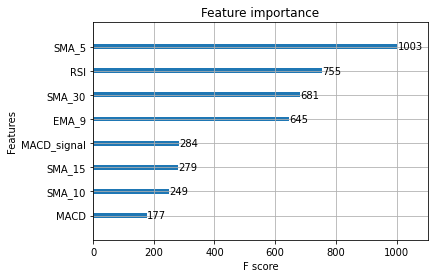

In [205]:
from xgboost import plot_importance, plot_tree
plot_importance(model)

In [206]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:10]}')
print(f'y_pred = {y_pred[:10]}')
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')


y_true = [63.83000183 64.15000153 64.59999847 65.08000183 65.87999725 66.44999695
 66.69999695 68.01000214 68.47000122 68.65000153]
y_pred = [60.41554  60.41554  60.41554  60.521313 60.862923 61.024048 62.00933
 62.616623 62.616623 62.977367]
mean_squared_error = 23.38376742824521


In [207]:
rmse=np.sqrt(np.mean(((y_pred- y_test)**2)))
rmse

4.835676522291912

In [208]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()